# Tutorila III

# PrettyTensor

En el tutorial anterior ([Tutorial II]) se mostró cómo implementar una red neuronal convolucional en TensorFlow. En dicho tutorial, se requería un conocimiento a bajo nivel de cómo funciona TensorFlow para el diseño e implementación de la red neuronal. 

[Tutorial II]:https://www.apsl.net/blog/2017/12/18/tensor-flow-para-principiantes-ii/

En éste tutorial, y  para el mismo ejemplo práctico usado en el [Tutorial II] (reconocimiento de dígitos escritos a mano), vamos explicar como usar el paquete adicional para TensorFlow llamado [PrettyTensor], también desarrollado por Google, para crear nuestra arquitectura de la red convolucional empleada en el [Tutorial II]. [PrettyTensor] proporciona formas mucho más simples de construir redes neuronales en TensorFlow, lo que nos permite centrarnos en la arquitectura de la red que deseamos implementar y no preocuparnos demasiado por los detalles de implementación a bajo nivel. Esto hace que el código fuente sea mucho más corto y fácil de leer y modificar.

[PrettyTensor]:https://github.com/google/prettytensor

La mayor parte del código fuente en este tutorial es idéntico al [Tutorial II], excepto por la construcción de los grafos, que ahora se hace usando [PrettyTensor], así como algunos cambios menores que idicaremos en el desarrollo de éste artículo, por lo que recomendamos revisar nuestro [Tutorial II].

Antes de continuar, recordemos el esquema de la red neuronal convolucinal que queremos implementar para la tarea del reconocimiento de dígitos escritos a mano, para ello veamos la siguinete imagen ya empleada en el [Tutorial II]. 


![F1](imagenes/02_network_flowchart.png)


Comenzamos por importar algunas librerias, incluyendo lalibreria [PrettyTensor]



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

# We also need PrettyTensor.
import prettytensor as pt

Cargamos el conjunto de datos MNIST que se descargará automáticamente si no se encuentra en la ruta dada.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Chequemaos que todo está correcto

In [3]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


Las etiquetas de clase son codificadas por One-Hot, lo que significa que cada etiqueta es un vector con 10 elementos, todos los cuales son cero a excepción de un elemento. El índice de este elemento es el número de clase, es decir, el dígito que se muestra en la imagen asociada. También necesitamos los números de clase como enteros para el conjunto de pruebas, por lo que ahora lo calculamos.

In [4]:
data.test.cls = np.argmax(data.test.labels, axis=1)

Pasamos a definir el conjunto de variables para dar formato a las dimensiones de nuestras imágenes:


In [5]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

Ahora crearemos nuestra función que es utilizada para trazar 9 imágenes en una cuadrícula de 3x3 y escribir las clases verdaderas y predichas debajo de cada imagen.

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Graficamos algunas imágenes para ver si los datos son correctos

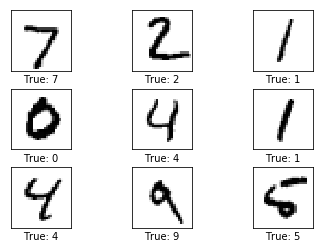

In [7]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

Las variables de marcador de posición (Placeholder variables)

Creamos las variables de marcador de posición como hicimos en el [Tutorial II] 

In [8]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

## Implementación de la Red Convolucional usando la librería PrettyTensor

Esta sección muestra cómo realizar exactamente la misma implementación de la red neuronal convolucional en el [Tutorial II] utilizando PrettyTensor.

La idea básica es envolver el tensor de entrada ** *x_image* ** en un objeto PrettyTensor que tiene funciones auxiliares para agregar nuevas capas computacionales a fin de crear una Red Neural completa. Esto es un poco similar a las funciones auxiliares que implementamos anteriormente, pero es aún más simple porque PrettyTensor también realiza un seguimiento de las dimensiones de entrada y salida de cada capa.



In [9]:
x_pretty = pt.wrap(x_image)

Ahora que hemos transformado la imagen de entrada en un objeto PrettyTensor, podemos agregar, tanto las capas convolucionales, como las capas totalmente conectadas en unas pocas líneas de código fuente.

In [10]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

Tenga en cuenta que en la función ** *pt.defaults_scope (activation_fn = tf.nn.relu)* **,  introduce la función de activiación ** *activation_fn = tf.nn.relu* ** como argumento para cada una de las capas construidas dentro del bloque ** with **, de modo que las unidades lineales rectificadas ** (ReLU) ** se usan para cada uno de estas capas. El * **defaults_scope** * hace que sea fácil cambiar los argumentos para todas las capas.

¡Eso es! Ahora hemos creado exactamente la misma red neuronal convolucional implementada en el [Tutorial II] en unas simples líneas de código, en contraste a las numerosas líneas de código que se requerían muchas en la implementación directa con TensorFlow.

Usando PrettyTensor, podemos ver claramente la estructura de la red y cómo los datos fluyen a través de la red. Esto nos permite centrarnos en las ideas principales de la Red Neural en lugar de detalles de implementación a bajo nivel. ¡Es simple y bonito!


# Obtener los pesos

Lamentablemente, no todo es bonito cuando se usa PrettyTensor.

Por ejemplo, si más adelante, queremos trazar los pesos de las capas convolucionales, la forma de recuperar estos pesos no es tan directa. En la implementación de TensorFlow (ver [Tutorial II]), nosotros mismos habíamos creado las variables, por lo que pudimos referirnos directamente a ellas. Pero cuando la red se construye utilizando PrettyTensor, todas las variables de las capas se crean indirectamente mediante PrettyTensor. Por lo tanto, tenemos que recuperar las variables de TensorFlow.

para ello utilizamos los nombres *layer_conv1* y *layer_conv2* para las dos capas convolucionales. Estos también se denominan **variable scopes** (no deben confundirse con defaults_scope). [PrettyTensor] asigna automáticamente nombres a las variables que crea para cada capa, de modo que podemos recuperar los pesos de una capa usando el nombre de la  **variable scopes** de la capa y el nombre de la variable.

La implementación es algo incómoda porque tenemos que usar la función TensorFlow get_variable () que fue diseñada para otro propósito; ya sea creando una nueva variable o reutilizando una variable existente. Lo más fácil es hacer la siguiente función auxiliar.

In [11]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

Usando esta función podemos recuperar las variables como objetos TensorFlow. Para obtener los contenidos de las variables, debe hacer algo como: **contents = session.run(weights_conv1)** como se muestrará más adelante.

Obtenemos los pesos:

In [12]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

# Método de optimización

PrettyTensor nos devuelve la etiqueta de clase  ** *class-label (y_pred)* **, así como una medida de pérdida que debe minimizarse, para mejorar la capacidad de la Red Neural para clasificar las imágenes de entrada.

Tenga en cuenta que la optimización no se realiza en este momento. De hecho, nada se calcula en absoluto, simplemente agregamos el objeto optimizador (optimizer-object) al grafo TensorFlow para su posterior ejecución.

In [13]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

# Medidas de desempeño

Necesitamos algunas medidas de rendimiento más para mostrar el progreso al usuario.

Primero calculamos el número de clase predicho a partir de la salida de la Red Neural ** *y_pred* **, que es un vector con 10 elementos. El número de clase es el índice del elemento más grande.

In [14]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Luego creamos un vector de booleanos que nos dice si la clase predicha es igual a la clase verdadera de cada imagen.

In [15]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

Calculamos  la precisión (accuracy) de la clasificación y transforma los booleanos a floats, de modo que False se convierte en 0 y True se convierte en 1. Luego calculamos el promedio de estos números.

In [16]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Una vez que se ha creado la red, tenemos que crear una sesión de TensorFlow y ejecutar el grafo.

In [17]:
session = tf.Session()

Inicializamos las variables:

In [18]:
session.run(tf.global_variables_initializer())

creamos la función de iteración para el proceso de optimización:

creamos la función de iteración para el proceso de optimización:

In [19]:
train_batch_size = 64

# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

Ahora crearemos algunas funciones para el monitoreo del comportamiento del modelo.

 * Función para trazar ejemplos de imágenes del conjunto de prueba que han sido clasificadas incorrectamente.


In [20]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

  * Función para calcular la matriz de confusión 

In [21]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

  * Función para imprimir la precisión de clasificación en el conjunto de prueba.

In [22]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

Miremos la precisión antes de cualquier optimización.

In [23]:
print_test_accuracy()

Accuracy on Test-Set: 11.4% (1139 / 10000)


Como vemos, la precisión del modelo es muy baja. Tiene sentido, puesto que no hemos optimizado ningún parámetro.

Mirémos ahora depuès de una iteración en el proceso de optimización:

In [24]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  10.9%
Time usage: 0:00:00


In [25]:
print_test_accuracy()

Accuracy on Test-Set: 13.1% (1309 / 10000)


como vemos como el modelo mejora un poco su precisión.

Rendimiento después de 100 iteraciones de optimización

In [26]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Time usage: 0:00:08


In [27]:
print_test_accuracy(show_example_errors=False)

Accuracy on Test-Set: 84.3% (8432 / 10000)


Después de 100 iteraciones de optimización, el modelo ha mejorado significativamente su precisión de clasificación.

Rendimiento después de 1000 iteraciones de optimización

In [28]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  87.5%
Optimization Iteration:    201, Training Accuracy:  87.5%
Optimization Iteration:    301, Training Accuracy:  84.4%
Optimization Iteration:    401, Training Accuracy:  85.9%
Optimization Iteration:    501, Training Accuracy:  89.1%
Optimization Iteration:    601, Training Accuracy:  95.3%
Optimization Iteration:    701, Training Accuracy:  96.9%
Optimization Iteration:    801, Training Accuracy:  93.8%
Optimization Iteration:    901, Training Accuracy:  98.4%
Time usage: 0:01:14


In [29]:
print_test_accuracy(show_example_errors=False)

Accuracy on Test-Set: 96.6% (9661 / 10000)



# Performance after 10,000 optimization iterations

After 10,000 optimization iterations, the model has a classification accuracy on the test-set of about 99%.


In [30]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy: 100.0%
Optimization Iteration:   1101, Training Accuracy:  96.9%
Optimization Iteration:   1201, Training Accuracy:  96.9%
Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy:  96.9%
Optimization Iteration:   1501, Training Accuracy: 100.0%
Optimization Iteration:   1601, Training Accuracy: 100.0%
Optimization Iteration:   1701, Training Accuracy: 100.0%
Optimization Iteration:   1801, Training Accuracy:  98.4%
Optimization Iteration:   1901, Training Accuracy:  96.9%
Optimization Iteration:   2001, Training Accuracy:  98.4%
Optimization Iteration:   2101, Training Accuracy: 100.0%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy: 100.0%
Optimization Iteration:   2401, Training Accuracy:  98.4%
Optimization Iteration:   2501, Training Accuracy:  96.9%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 98.9% (9889 / 10000)
Confusion Matrix:
[[ 973    0    0    0    0    1    2    1    3    0]
 [   0 1133    1    0    0    0    0    0    1    0]
 [   2    2 1015    2    1    0    1    3    6    0]
 [   0    0    0 1007    0    1    0    0    2    0]
 [   0    0    0    0  978    0    0    0    0    4]
 [   2    0    1    6    0  876    1    0    3    3]
 [   7    3    0    1    1    1  945    0    0    0]
 [   0    2    7    2    1    0    0 1006    1    9]
 [   4    0    2    0    1    1    0    2  961    3]
 [   0    3    0    1    5    4    0    0    1  995]]


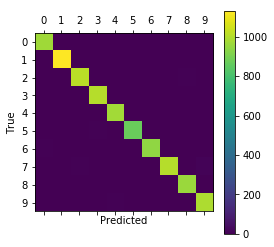

In [31]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

# Visualización de pesos y capas

Cuando la red neuronal convolucional se implementó directamente en TensorFlow, podemos graficar fácilmente tanto los pesos convolucionales como las imágenes que salieron de las diferentes capas. Sin embargo, cuando se emplea PrettyTensor recuperar los pesos y las imágenes no es tandirecto, pero podemos recuperar  las imágenes que salen de las capas convolucionales, cerando una función para ello:

In [32]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Capa convolucional 1

Ahora mostramos los imágenes de los pesos de los filtros en la primera capa de convolución de la red (rojo para valores positivos y azules para valores negativos):


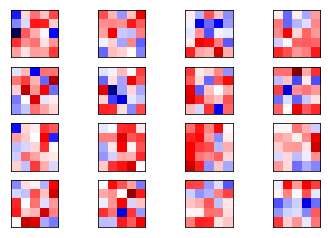

In [33]:
plot_conv_weights(weights=weights_conv1)

## Capa convolucional 2

Ahora grafica los pesos de los filtros para la segunda capa convolucional. Dado que hay 16 canales de salida desde la primera capa convolucional, entonces tendremos 16 canales de entrada para la segunda capa convolucional. La segunda capa convolucional tiene un conjunto de filtros de los pesos  para cada uno de sus canales de entrada. Comenzamos por graficar los pesos del filtro para el primer canal. Note nuevamente que los pesos positivos son rojos y los pesos negativos son azules.

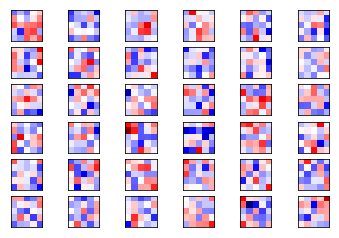

In [34]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

Ahora para el canal 2

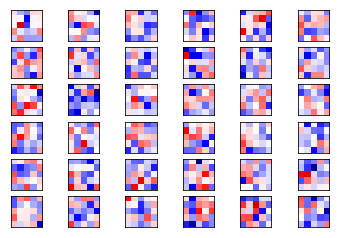

In [35]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

In [36]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()


# Conclusión

Como hemos visto, [PrettyTensor] permite implementar redes neuronales usando una sintaxis mucho más simple que una implementación directa en TensorFlow. Hace que el código sea mucho más corto y fácil de entender, y por tanto cometer menos errores.

Hay alternativas a PrettyTensor incluyendo TFLearn y Keras, que iremos implemenatdo en próximos tutoriales.


# Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

   * Change the activation function to sigmoid for all the layers.
   * Use sigmoid in some layers and relu in others. Can you use defaults_scope for this?
   * Use l2loss in all layers. Then try it for only some of the layers.
   * Use PrettyTensor's reshape for x_image instead of TensorFlow's. Is one better than the other?
   * Add a dropout-layer after the fully-connected layer. If you want a different keep_prob during training and testing then you will need a placeholder variable and set it in the feed-dict.
   * Replace the 2x2 max-pooling layers with stride=2 in the convolutional layers. Is there a difference in classification accuracy? What if you optimize it again and again? The difference is random, so how would you measure if there really is a difference? What are the pros and cons of using max-pooling vs. stride in the conv-layer?
   * Change the parameters for the layers, e.g. the kernel, depth, size, etc. What is the difference in time usage and classification accuracy?
   * Add and remove some convolutional and fully-connected layers.
    What is the simplest network you can design that still performs well?
    Retrieve the bias-values for the convolutional layers and print them. See get_weights_variable() for inspiration.
   * Remake the program yourself without looking too much at this source-code.
   * Explain to a friend how the program works.

